<a href="https://colab.research.google.com/github/Jathurshan0330/BRATS-Brain-Tumor-Segmentation/blob/master/170248G_BM4301_Brain_Tumor_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Get Requirements

In [7]:
from IPython.display import clear_output

In [8]:
!pip install itk itkwidgets ipywidgets
clear_output()

In [9]:
#Import Libraries
import itk
import numpy as np
import nibabel as nib
import itk
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

#Load Data

In [84]:
base = '/content/drive/MyDrive/brats2018/Brats18_2013_10_1_'

flair_fn = base + 'flair.nii'
t1_fn = base + 't1.nii'
t1ce_fn = base + 't1ce.nii'
t2_fn = base + 't2.nii'
seg_fn = base + 'seg.nii'

flair = itk.imread(flair_fn)
t1 = itk.imread(t1_fn)
t1ce = itk.imread(t1ce_fn)
t2 = itk.imread(t2_fn)
seg = itk.imread(seg_fn)
print(flair.shape, t1.shape, t1ce.shape, t2.shape, seg.shape)


flair = flair.astype(itk.F)
t1 = t1.astype(itk.F)
t1ce = t1ce.astype(itk.F)
t2 = t2.astype(itk.F)


(155, 240, 240) (155, 240, 240) (155, 240, 240) (155, 240, 240) (155, 240, 240)


## Visulaization

(<matplotlib.image.AxesImage at 0x7f08f3adc650>, Text(0.5, 1.0, 'seg'))

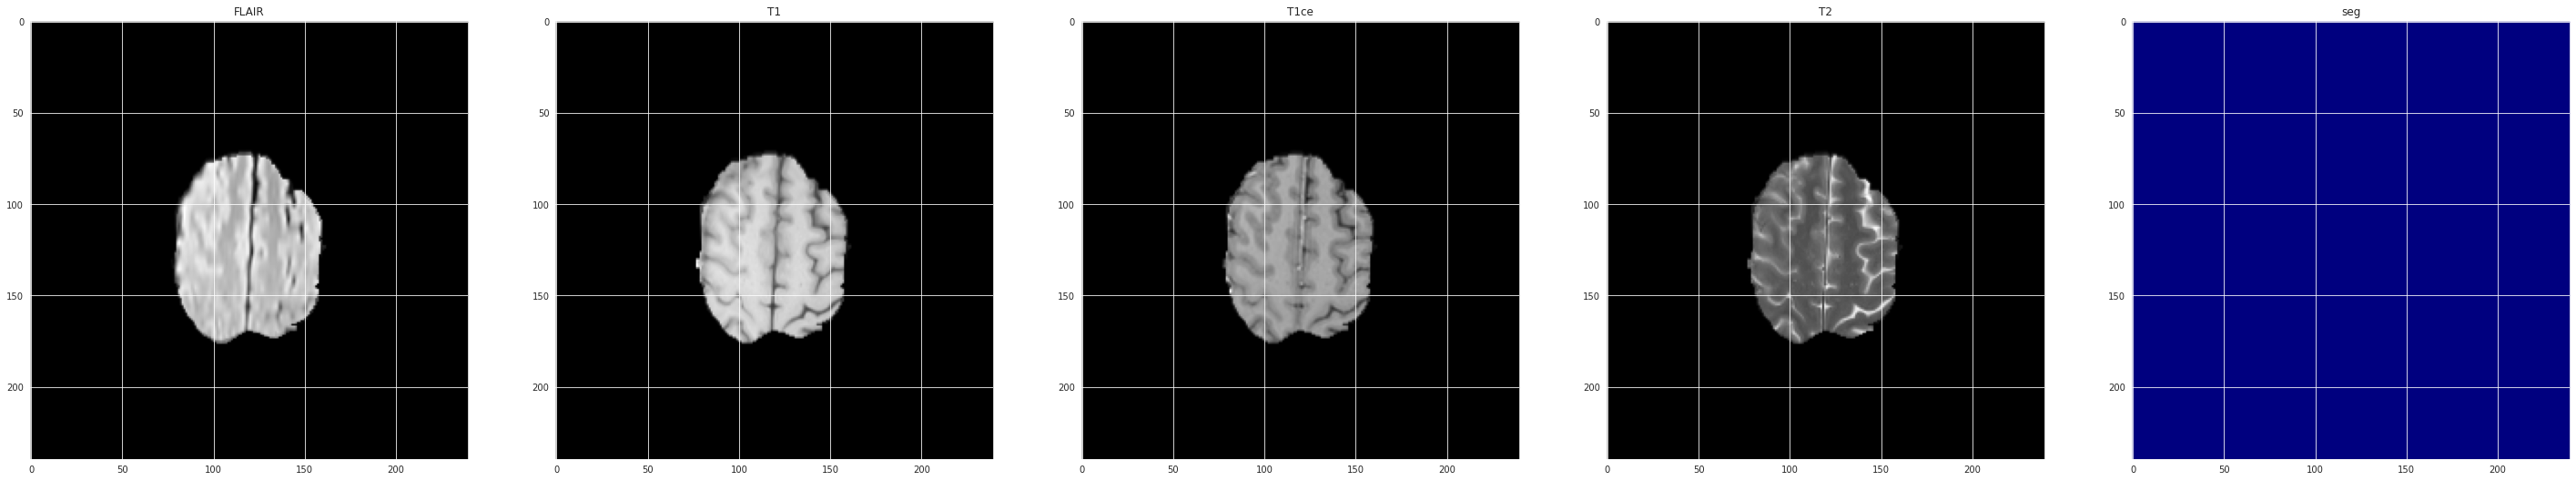

In [85]:
#Visualize images
slice = 125
fig, ax = plt.subplots(1,5, figsize=(50,10))
ax[0].imshow(flair[slice], cmap='gray'), ax[0].set_title('FLAIR')
ax[1].imshow(t1[slice], cmap='gray'), ax[1].set_title('T1')
ax[2].imshow(t1ce[slice], cmap='gray'), ax[2].set_title('T1ce')
ax[3].imshow(t2[slice], cmap='gray'), ax[3].set_title('T2')
ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('seg')

In [86]:
#Interactive visualization
# Create layer slider
select_slice = IntSlider(min=0, max=flair.shape[0]-1, description='Select Slice', continuous_update=False)

# Define a function for plotting images
def plot_image(slice):
    print(f"Plotting {slice} Slice")
    fig, ax = plt.subplots(1,5, figsize=(50,10))
    ax[0].imshow(flair[slice], cmap='gray'), ax[0].set_title('FLAIR')
    ax[1].imshow(t1[slice], cmap='gray'), ax[1].set_title('T1')
    ax[2].imshow(t1ce[slice], cmap='gray'), ax[2].set_title('T1ce')
    ax[3].imshow(t2[slice], cmap='gray'), ax[3].set_title('T2')
    ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('seg')


# Use the interactive() tool to create the visualization
interactive(plot_image, slice=select_slice)
    

interactive(children=(IntSlider(value=0, continuous_update=False, description='Select Slice', max=154), Output…

In [87]:
from seaborn.matrix import clustermap
def interactive_plot(flair_1,t1_1,t1ce_1,t2_1,seg_1, cmap = 'jet'):
  def plot_image(slice):
    print(f"Plotting {slice} Slice")
    fig, ax = plt.subplots(1,5, figsize=(50,10))
    ax[0].imshow(flair[slice], cmap='gray'), ax[0].set_title('FLAIR',fontsize = 50)
    ax[1].imshow(t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 50)
    ax[2].imshow(t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 50)
    ax[3].imshow(t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 50)
    ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('seg',fontsize = 50)
    plt.show()

    fig, ax = plt.subplots(1,5, figsize=(50,10))
    ax[0].imshow(flair_1[slice], cmap=cmap), ax[0].set_title('FLAIR',fontsize = 50)
    ax[1].imshow(t1_1[slice], cmap=cmap), ax[1].set_title('T1',fontsize = 50)
    ax[2].imshow(t1ce_1[slice], cmap=cmap), ax[2].set_title('T1ce',fontsize = 50)
    ax[3].imshow(t2_1[slice], cmap=cmap), ax[3].set_title('T2',fontsize = 50)
    ax[4].imshow(seg_1[slice], cmap='jet'), ax[4].set_title('seg',fontsize = 50)
    plt.show()
  select_slice = IntSlider(min=0, max=flair.shape[0]-1, description='Select Slice', continuous_update=False)
  return interactive(plot_image, slice=select_slice)

interactive_plot(flair,t1,t1ce,t2,seg, cmap = 'gray')

interactive(children=(IntSlider(value=0, continuous_update=False, description='Select Slice', max=154), Output…

# Segmentation using 5 algorithms in ITK

Segmentation algorithms are built with the aid of ITK documentation :
https://itk.org/ITKExamples

## Watershed Image Filter

Segmentation of the tumor using the watershed method

In [88]:
"""
WatershedImageFilter function in ITK is used.

threshold : absolute minimum height value used during processing.
            Raising this threshold percentage effectively decreases the number of local minima in the input,
            resulting in an initial segmentation with fewer regions.

evel: parameter controls the depth of metaphorical flooding of the image.
       That is, it sets the maximum saliency value of interest in the result.
       Raising and lowering the Level influences the number of segments
       in the basic segmentation that are merged to produce the final output.
       A level of 1.0 is analogous to flooding the image up to a
       depth that is 100 percent of the maximum value in the image.
       A level of 0.0 produces the basic segmentation, which will typically be very oversegmented.
       Level values of interest are typically low (i.e. less than about 0.40 or 40%),
       since higher values quickly start to undersegment the image.
"""
# threshold = 0.001
# level = 0.2
# conductance = 2.0
# iterations = 10
# pr_comp = False   #principal components

flair_grad_mag_filt = itk.GradientMagnitudeImageFilter(flair)
t1_grad_mag_filt = itk.GradientMagnitudeImageFilter(t1)
t1ce_grad_mag_filt = itk.GradientMagnitudeImageFilter(t1ce)
t2_grad_mag_filt = itk.GradientMagnitudeImageFilter(t2)

flair_watershed = itk.WatershedImageFilter(flair_grad_mag_filt,threshold = 0.001, level = 0.15)
t1_watershed = itk.WatershedImageFilter(t1_grad_mag_filt,threshold = 0.001, level = 0.2)
t1ce_watershed = itk.WatershedImageFilter(t1ce_grad_mag_filt,threshold = 0.001, level = 0.2)
t2_watershed = itk.WatershedImageFilter(t2_grad_mag_filt,threshold = 0.001, level = 0.2)

In [89]:
interactive_plot(flair_watershed,t1_watershed,t1ce_watershed,t2_watershed,seg, cmap = 'jet')


interactive(children=(IntSlider(value=0, continuous_update=False, description='Select Slice', max=154), Output…

## Otsu Segmentation

In [90]:
#OtsuThresholdImageFilter

flair_otsu = itk.OtsuThresholdImageFilter(flair, OutsideValue = 0, InsideValue = 1)
t1_otsu = itk.OtsuThresholdImageFilter(t1)
t1ce_otsu = itk.OtsuThresholdImageFilter(t1ce)
t2_otsu = itk.OtsuThresholdImageFilter(t2)


In [91]:
interactive_plot(flair_otsu,t1_otsu,t1ce_otsu,t2_otsu,seg, cmap = 'jet')

interactive(children=(IntSlider(value=0, continuous_update=False, description='Select Slice', max=154), Output…

## Neighborhood Connected

In [106]:
#NeighborhoodConnectedImageFilter


#CurvatureFlowImageFilter is used here to smooth the image while preserving edges.
flair_smooth = itk.curvature_flow_image_filter(flair, number_of_iterations = 5, time_step = 0.125)
t1_smooth = itk.curvature_flow_image_filter(t1, number_of_iterations = 5, time_step = 0.125)
t1ce_smooth = itk.curvature_flow_image_filter(t1ce, number_of_iterations = 5, time_step = 0.125)
t2_smooth = itk.curvature_flow_image_filter(t2, number_of_iterations = 5, time_step = 0.125)


flair_nc = itk.NeighborhoodConnectedImageFilter(flair_smooth,Radius = 2, Seed =150 )
t1_nc = itk.NeighborhoodConnectedImageFilter(t1_smooth)
t1ce_nc = itk.NeighborhoodConnectedImageFilter(t1ce_smooth)
t2_nc = itk.NeighborhoodConnectedImageFilter(t2_smooth)

In [107]:
interactive_plot(flair_nc,t1_nc,t1ce_nc,t2_nc,seg, cmap = 'jet')

interactive(children=(IntSlider(value=0, continuous_update=False, description='Select Slice', max=154), Output…